In [1]:
import pandas as pd
import numpy as np
import pickle
import spacy

In [2]:
df = pd.read_pickle('goszakupki_okpd_data.pickle')
df

,text,OKPD2
0,Укроп свежий,01.13.19.000
1,Яблоки,01.24.10.000
2,Капуста брокколи,01.13.13.000
3,Морковь столовая,01.13.41.110
4,Яйца куриные в скорлупе свежие,01.47.21.000
...,...,...
8558341,Ш-15 (Р-152) Ежегодное освидетельствование\r\n,99.00.10.000
8558342,КПЛ-1 (Р-99) Наружное освидетельствование сосу...,99.00.10.000
8558343,ЖУЛАН (391А) Внеочередное освидетельствование....,99.00.10.000
8558344,ДТС-2 (306К) Ежегодное освидетельствование\r\n,99.00.10.000


##### Анализируя замечаем что много пустых классов, где количество записей по конкретному коду  < 10, что будет сильно мешать алгоритму, так что уберём эти данные 

In [3]:
dsfg = df.groupby('OKPD2').count()
dsfg.sort_values('text')

,text
OKPD2,
10.81.14.110,1
10.82.23.125,1
13.92.15.130,1
30.11.32.114,1
10.12.40.119,1
...,...
71.12.40.129,119091
80.10.12.000,119196
36.00.20.130,129134


Самая частовстречаемая кодировка - ***Части и принадлежности для автотранспортных средств прочие, не включенные в другие группировки***

In [4]:
df[df['OKPD2']=='29.32.30.390'].head()

,text,OKPD2
3094920,Хомут силовой (131-139) 26мм (М8х70),29.32.30.390
3094921,6522-3501125 кронштейн,29.32.30.390
3094922,"Подшипник редуктора моста МАЗ-5440,6430,5516А5...",29.32.30.390
3094923,"Пробка поддона двигателя _ (М28*1,5) с магнитом",29.32.30.390
3094924,Антифриз,29.32.30.390


<Axes: xlabel='OKPD2'>

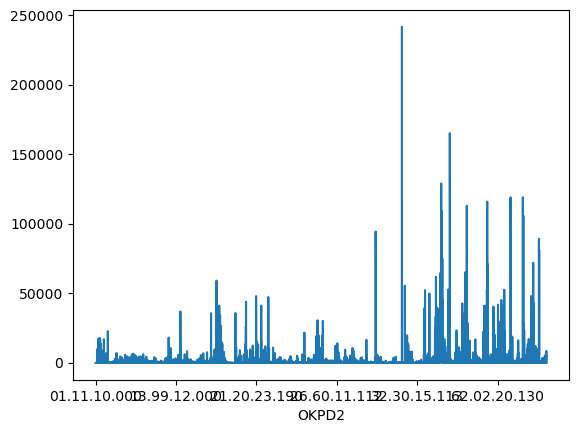

In [5]:
dsfg[dsfg['text'] > 10]['text'].plot()

Статистическое описание данных после группировки

In [6]:
dsfg[dsfg['text'] > 10].describe()

,text
count,5606.000000
mean,1524.461827
std,7828.713467
min,11.000000
25%,32.000000
50%,104.000000
75%,489.750000
max,241739.000000


Формальная группировка (выведена в отдельный файл)

In [7]:
# Сначала подсчитаем, сколько раз каждое значение OKPD2 встречается в таблице
counts = df['OKPD2'].value_counts()
print(counts.head())
# Теперь отфильтруем counts, чтобы оставить только значения с более чем 10 вхождениями
filtered_counts = counts[counts > 10]

# Фильтруем исходный df, оставляя только строки с OKPD2, которые есть в filtered_counts
filtered_df = df[df['OKPD2'].isin(filtered_counts.index)].copy()

# В результате filtered_df содержит только те записи, где значение OKPD2 встречается более 10 раз.
filtered_df.head()

OKPD2
29.32.30.390    241739
42.11.20.300    165264
36.00.20.130    129134
80.10.12.000    119196
71.12.40.129    119091
Name: count, dtype: int64


,text,OKPD2
0,Укроп свежий,01.13.19.000
1,Яблоки,01.24.10.000
2,Капуста брокколи,01.13.13.000
3,Морковь столовая,01.13.41.110
4,Яйца куриные в скорлупе свежие,01.47.21.000


In [8]:
# проверим что всё правильно
filtered_df_group = filtered_df.groupby('OKPD2').count()
filtered_df_group.sort_values('text')

,text
OKPD2,
28.25.11.112,11
10.84.23.170,11
30.20.40.171,11
25.99.12.120,11
10.86.10.122,11
...,...
71.12.40.129,119091
80.10.12.000,119196
36.00.20.130,129134


Подготовим два файла:  
1. Просто 200к записей +- равномерно по первому коду классификатора
2. 200к записей == 100 наиболей встречаемых классов, из них по 1к записей в каждом 

In [9]:
filtered_df['new_code'] = filtered_df['OKPD2'].apply(lambda x: x.split('.')[0])
filtered_df.head()

,text,OKPD2,new_code
0,Укроп свежий,01.13.19.000,01
1,Яблоки,01.24.10.000,01
2,Капуста брокколи,01.13.13.000,01
3,Морковь столовая,01.13.41.110,01
4,Яйца куриные в скорлупе свежие,01.47.21.000,01


In [10]:
filtered_df_only_1_step = filtered_df.drop('OKPD2', axis=1).copy()

In [11]:
random_sample = filtered_df_only_1_step.sample(n=200000, random_state=1019)
random_sample.head()

,text,new_code
4004427,Термостат суховоздушный ТВ-80-1,33
4551450,Услуги по холодному водоснабжению,36
6579286,СС КонсультантСудебнаяПрактика: Суды Москвы и ...,62
1028808,Короб архивный на завязках № 1,17
2281960,Степлер,25


Проверка распределения random_sample

In [12]:
random_sample.groupby('new_code')['text'].count().sort_values()

new_code
87       7
99       9
50      11
69      26
03      27
      ... 
01    5902
71    5916
81    5945
20    5950
17    5971
Name: text, Length: 82, dtype: int64

In [ ]:
#random_sample.to_pickle("random_sample_200k.pickle")

In [13]:
filtered_df = filtered_df.drop('new_code', axis=1)

In [14]:
top_100_classes = filtered_df['OKPD2'].value_counts().nlargest(100).index

In [15]:
samples_per_class = 2000
final_sample = pd.DataFrame()

for class_value in top_100_classes:
    class_sample = filtered_df[filtered_df['OKPD2'] == class_value].sample(n=samples_per_class, random_state=1)
    final_sample = pd.concat([final_sample, class_sample], ignore_index=True)

In [16]:
final_sample.groupby('OKPD2').count()

,text
OKPD2,
01.13.12.120,2000
01.13.41.110,2000
01.13.43.110,2000
01.13.49.110,2000
01.24.10.000,2000
...,...
86.90.19.110,2000
86.90.19.190,2000
95.11.10.110,2000


In [ ]:
# final_sample.to_pickle("top_100_class_200k.pickle")